# Sentiment Analysis & Tweet Topic Modelling

The present notebook is part of a series of notebooks related to the MSc. thesis: **Sentiment analysis on generative language models based on Social Media commentary of industry participants**

The MSc. thesis research was conducted based on tweets about ChatGPT. These were collected, processed and analyzed with the scope of answering the following research question:

**How are generative language models perceived by participants of different industries based on social media commentary?**

In answering the research question a focal point consists of determining the sentiments of the tweets about ChatGPT. To do so, this notebook showcases how a pretrained lexicon-based model, Vader, was employed to get the polarity of each tweet. Based on these polarities the tweets were then assigned either a Positive, Neutral or Negative label. 

To gain more insights related to the the tweets on ChatGPT, the second part of this notebook centers around finding the topics that were touched upon in these tweets. 
For topic modelling two methods were tried: Latent Dirichlet Allocation and key-work analysis. The results of these analysis techniques were not fully conclusive due to data considerations.

In [2]:
#Import cell of necessary packages
import pandas as pd
from pandas import option_context
import numpy as np
import datetime
import ast #for reading data as specific data type
import re, string #for regex data cleaning 
from string import digits #for handling digits 
import itertools
import ast

#Tweet cleaning package
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION)

#Set pandas options for ease of cleaning
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

#Import to surpass long future warnings
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Import package for comparing value to key dict
from functools import cmp_to_key 

#Import coherence to find most optimal number of topics
from gensim.models import CoherenceModel

#Import for visualisations
from matplotlib import pyplot as plt
#Package for wordclouds
from wordcloud import WordCloud, STOPWORDS

#Import Vader for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Import LDA model packages
from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore #we'll use the faster multicore version of LDA

#Import to visualize LDA models
import pyLDAvis
#Import to save LDA models
import pyLDAvis.gensim_models as gensimvis
from gensim import  models

#Import module for VADER performance assesment
from sklearn.metrics import classification_report

## Tweet Sentiment Analysis

This section showcases how the the sentiment of tweets is deducted by using a pre-trained lexicon based mode: Vader. 

In [2]:
#Read tokanized tweets data
sentiment_df = pd.read_csv('data_files/Tweets_PreLDA.csv')
sentiment_df['tweet_id']=sentiment_df['tweet_id'].astype(str)
sentiment_df.head(3)

,Unnamed: 0,tweet_id,tweet_content,tweet_content_hashtags,tweet_content_mentions,tweet_content_URLs,tweet_content_emoji,tweet_content_clean,tweet_content_tokens,tweet_content_tokens_no_verbs
0,0,1644446066748854281,"What's happening, it asks, and I reply that ch...",['teaching'],[],[],NaN,whats happening it asks and i reply that chat ...,"['class', 'kind', 'world', 'english', 'alterna...","['class', 'kind', 'world', 'english', 'alterna..."
1,1,1644442136664764444,"...one in the depot is approximately 17,42 MB ...",[],[],[],NaN,one in the depot is approximately mb in size t...,"['correct', 'size', 'chatgpt', 'depot', 'curre...","['correct', 'size', 'chatgpt', 'depot', 'curre..."
2,2,1644437753721942044,I’ve converted to chatgpt,[],[],[],NaN,ive converted to chatgpt,['chatgpt'],['chatgpt']


In [5]:
#Inspect tweet_content column
with option_context('display.max_colwidth', 400):
    display(sentiment_df[['tweet_id','tweet_content']].head(10))

,tweet_id,tweet_content
0,1644446066748854281,"What's happening, it asks, and I reply that chat GPT has my comp class in the fall as a kind of video game. Create an alternative you and then you and I work together to save the world from English. #teaching"
1,1644442136664764444,"...one in the depot is approximately 17,42 MB in size! The current american.gxt is 4,97 MB in size, and in the depot it is approximately 5,22 MB in size! If the conversions are correct (The conversions where done from MiB to MB via ChatGPT), then that means that they..."
2,1644437753721942044,I’ve converted to chatgpt
3,1644433541827280896,"Asked #chatgpt if someone has a BMI of 29, are they obese, and it gave me a reply about a bmi of 29 having health risks, however, it did not account for the fact that body fat %age also factors in to the health of a person. Goes to show that docs can’t be replaced by AI yet"
4,1644429028307406849,How does ChatGPT train its AI using advanced hardware? Find out in my new blog post where I explore the secrets of ChatGPT’s AI training. \nhttps://t.co/Wo2IQqh1WG\n#ChatGPT #AI #Hardware #blog
5,1644424509217206277,I CAN DO SCRIPTS ASWELL!!
6,1644421142399053843,@enokay69 This one dier chatgpt oo 😂
7,1644417202928459782,"@Ajax777 Why? They can become 10X writers with ChatGPT, just like I did."
8,1644414016062910465,ChatGPT is the engineering friend group I never got to make because I didn't get to finish my degree at GaTech because of $$$
9,1644409427544481827,"@Aslan_Bey_1 ChatGPT doesnt even say he was the Messiah, it says he claimed he was. Two completely different things 😂😂\n\nSo they're excited because they lack reading skills."


In [6]:
#Create Sentiment Analisys Analyzer object
analyzer = SentimentIntensityAnalyzer()

Before fitting the *analyzer* object to the tweets data, some pre-cleaning on the content of the tweets was done. This consisted in removal of urls and mentions, and in getting the content of hashtags as independent words. No further cleaning was needed as according to [*Vader's documentation*](https://github.com/cjhutto/vaderSentiment#features-and-updates) Vader performs well with emojis, punctuation and letter-capitalisation.

Code inspo for splitting hashtags: 
https://stackoverflow.com/questions/68448243/efficient-way-to-split-multi-word-hashtag-in-python

In [7]:
#Naive function of hashtag removal
#Function below was inspired by the answers in this stackoverflow thread: https://stackoverflow.com/questions/68448243/efficient-way-to-split-multi-word-hashtag-in-python
def do_process_eng_hashtag(input_text: str) -> str:
    return re.sub(
        r'#[a-zA-Z0-9]\S*',
        lambda m: 
        ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*', m.group().lstrip('#'))) 
        if len(m.group().lstrip('#')) >3 else m.group().lstrip('#'),
        input_text,
    )
#Function to remove mentions and usl
def prepro_sentiment(dataframe, dataframe_column):
    #Remove urls and mentions
    dataframe[f'{dataframe_column}_sentiment_prepro'] = dataframe[f'{dataframe_column}'].apply(lambda x: p.clean(str(x)))
    print('cleaning done')
    #Split hashtags
    dataframe[f'{dataframe_column}_sentiment_prepro'] = dataframe[f'{dataframe_column}_sentiment_prepro'] .apply(lambda x: do_process_eng_hashtag(str(x)))
    #remove digits 
    print('hashtags done')
    dataframe[f'{dataframe_column}_sentiment_prepro'] = dataframe[f'{dataframe_column}_sentiment_prepro'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

    return dataframe

In [8]:
#Create dataframe of only columns needed for sentiment analysis 
sentiment_processed_df = sentiment_df[['tweet_id','tweet_content']]

In [9]:
#Pre-process tweet_content
sentiment_processed_df = prepro_sentiment(sentiment_processed_df, 'tweet_content')

cleaning done
hashtags done


In [65]:
#Inspect results of preprocessing
with option_context('display.max_colwidth', 400):
    display(sentiment_processed_df[['tweet_id','tweet_content','tweet_content_sentiment_prepro']].head(15))

,tweet_id,tweet_content,tweet_content_sentiment_prepro
0,1644446066748854281,"What's happening, it asks, and I reply that chat GPT has my comp class in the fall as a kind of video game. Create an alternative you and then you and I work together to save the world from English. #teaching","What's happening, it asks, and I reply that chat GPT has my comp class in the fall as a kind of video game. Create an alternative you and then you and I work together to save the world from English. teaching"
1,1644442136664764444,"...one in the depot is approximately 17,42 MB in size! The current american.gxt is 4,97 MB in size, and in the depot it is approximately 5,22 MB in size! If the conversions are correct (The conversions where done from MiB to MB via ChatGPT), then that means that they...","...one in the depot is approximately , MB in size! The current american.gxt is , MB in size, and in the depot it is approximately , MB in size! If the conversions are correct (The conversions where done from MiB to MB via ChatGPT), then that means that they..."
2,1644437753721942044,I’ve converted to chatgpt,I’ve converted to chatgpt
3,1644433541827280896,"Asked #chatgpt if someone has a BMI of 29, are they obese, and it gave me a reply about a bmi of 29 having health risks, however, it did not account for the fact that body fat %age also factors in to the health of a person. Goes to show that docs can’t be replaced by AI yet","Asked chatgpt if someone has a BMI of , are they obese, and it gave me a reply about a bmi of having health risks, however, it did not account for the fact that body fat %age also factors in to the health of a person. Goes to show that docs can’t be replaced by AI yet"
4,1644429028307406849,How does ChatGPT train its AI using advanced hardware? Find out in my new blog post where I explore the secrets of ChatGPT’s AI training. \nhttps://t.co/Wo2IQqh1WG\n#ChatGPT #AI #Hardware #blog,How does ChatGPT train its AI using advanced hardware? Find out in my new blog post where I explore the secrets of ChatGPT’s AI training. Chat G P T AI Hardware blog
5,1644424509217206277,I CAN DO SCRIPTS ASWELL!!,I CAN DO SCRIPTS ASWELL!!
6,1644421142399053843,@enokay69 This one dier chatgpt oo 😂,This one dier chatgpt oo 😂
7,1644417202928459782,"@Ajax777 Why? They can become 10X writers with ChatGPT, just like I did.","Why? They can become X writers with ChatGPT, just like I did."
8,1644414016062910465,ChatGPT is the engineering friend group I never got to make because I didn't get to finish my degree at GaTech because of $$$,ChatGPT is the engineering friend group I never got to make because I didn't get to finish my degree at GaTech because of $$$
9,1644409427544481827,"@Aslan_Bey_1 ChatGPT doesnt even say he was the Messiah, it says he claimed he was. Two completely different things 😂😂\n\nSo they're excited because they lack reading skills.","ChatGPT doesnt even say he was the Messiah, it says he claimed he was. Two completely different things 😂😂 So they're excited because they lack reading skills."


To asses how VADER performs on the given dataset, a small sampled was hand-labelled by the authors of this study. The results of VADER were then compared to the manually  labelled data to calculate the recall, precision and F1 score of VADER's performance

In [14]:
#Get 250 rows sample
n_test_rows= 250
test_set= sentiment_processed_df.sample(n_test_rows).reset_index()
test_set.shape
#TODO:remove comment to save sample of data
#test_set.to_csv('test_set_unlabelled.csv',index=False)

In [ ]:
#Small script used in manually labelling the data
for row in range(test_set.shape[0]):
    #Slice dataframe so row by row can be appended in resulting csv file
    df_to_append = test_set[test_set.index==row]
    #Display tweet and request input value
    input_val = input(f"ROW:{row} \nTweet { test_set['tweet_content_sentiment_prepro'][row]}\n Insert Rating: ")
    #Assign input value to df_to_append column
    df_to_append[row,'sentiment_hand_labelled']= input_val
    df_to_append.to_csv('hand_labelled_data.csv',index=False,mode='a',header=False)   

    if input_val=='x':
        break
   
#Values: 0 - Neutral, 1 - Negative, 2- Positive 

In [47]:
#read manually labelled data
results= pd.read_csv('data_files/hand_labelled_data.csv',names=['idx','tweet_id','tweet_content','tweet_content_sentiment_prepro','sentimen_label_manual']).drop(columns='idx').reset_index()
results.head()

,index,tweet_id,tweet_content,tweet_content_sentiment_prepro,sentimen_label_manual
0,0,1613078056104493056,If you are looking to get professional access ...,If you are looking to get professional access ...,2
1,1,1631035154633457664,I used ChatGPT to write a contract for me and ...,I used ChatGPT to write a contract for me and ...,2
2,2,1599824753417560064,what happens when these chatGPT systems fail i...,what happens when these chatGPT systems fail i...,1
3,3,1625356830812536839,@iexistentiai I cannot stop reading the chatgp...,I cannot stop reading the chatgpt and bing red...,2
4,4,1643078207770615808,@google used #ChatGPT data sets to improve #BA...,used Chat G P T data sets to improve B A R D. ...,2


In [48]:
#Get polarity scores per tweet
results['vader_polarity'] = results['tweet_content_sentiment_prepro'].apply(lambda x: analyzer.polarity_scores(x))

In [49]:
#Inspect dataframe
results.head()

,index,tweet_id,tweet_content,tweet_content_sentiment_prepro,sentimen_label_manual,vader_polarity
0,0,1613078056104493056,If you are looking to get professional access ...,If you are looking to get professional access ...,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,1,1631035154633457664,I used ChatGPT to write a contract for me and ...,I used ChatGPT to write a contract for me and ...,2,"{'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'comp..."
2,2,1599824753417560064,what happens when these chatGPT systems fail i...,what happens when these chatGPT systems fail i...,1,"{'neg': 0.216, 'neu': 0.651, 'pos': 0.134, 'co..."
3,3,1625356830812536839,@iexistentiai I cannot stop reading the chatgp...,I cannot stop reading the chatgpt and bing red...,2,"{'neg': 0.173, 'neu': 0.706, 'pos': 0.121, 'co..."
4,4,1643078207770615808,@google used #ChatGPT data sets to improve #BA...,used Chat G P T data sets to improve B A R D. ...,2,"{'neg': 0.0, 'neu': 0.952, 'pos': 0.048, 'comp..."


In [51]:
#Function to assign sentiment per tweet based on compound polarity
def polarity_assignement(dataframe_input): 
    for i in range(dataframe_input.shape[0]):
        compound = dataframe_input.at[i,'vader_polarity']['compound']
        
        if compound > 0.05:
            dataframe_input.at[i,'sentiment'] = "Positive"
        elif compound < -0.05:
            dataframe_input.at[i,'sentiment'] = "Negative"
        else:
            dataframe_input.at[i,'sentiment'] = "Neutral"
    return dataframe_input

In [54]:
#Dict to map values in sentiment_label_manual column
manual_vals = {0:'Neutral',1:'Negative',2:'Positive'}

In [55]:
##Assign polarity categories
polarity_assignement(results)
results['sentimen_label_manual']=results['sentimen_label_manual'].map(manual_vals)
results.head(3)

,index,tweet_id,tweet_content,tweet_content_sentiment_prepro,sentimen_label_manual,vader_polarity,sentiment
0,0,1613078056104493056,If you are looking to get professional access ...,If you are looking to get professional access ...,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
1,1,1631035154633457664,I used ChatGPT to write a contract for me and ...,I used ChatGPT to write a contract for me and ...,Positive,"{'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'comp...",Positive
2,2,1599824753417560064,what happens when these chatGPT systems fail i...,what happens when these chatGPT systems fail i...,Negative,"{'neg': 0.216, 'neu': 0.651, 'pos': 0.134, 'co...",Negative


In [63]:
#Asses VADER performance
y_true = results['sentimen_label_manual']
y_pred = results['sentiment']
print(classification_report(y_true, y_pred, labels=['Positive', 'Negative', 'Neutral']))
 

              precision    recall  f1-score   support

    Positive       0.58      0.68      0.63       114
    Negative       0.50      0.31      0.38        68
     Neutral       0.47      0.53      0.50        68

    accuracy                           0.54       250
   macro avg       0.52      0.50      0.50       250
weighted avg       0.53      0.54      0.53       250



In [66]:
#Get polarity scores for entire dataset
sentiment_processed_df['vader_polarity'] = sentiment_processed_df['tweet_content_sentiment_prepro'].apply(lambda x: analyzer.polarity_scores(x))

In [67]:
#Assign polarity category
polarity_assignement(sentiment_processed_df)

,tweet_id,tweet_content,tweet_content_sentiment_prepro,vader_polarity,sentiment
0,1644446066748854281,"What's happening, it asks, and I reply that ch...","What's happening, it asks, and I reply that ch...","{'neg': 0.0, 'neu': 0.88, 'pos': 0.12, 'compou...",Positive
1,1644442136664764444,"...one in the depot is approximately 17,42 MB ...","...one in the depot is approximately , MB in s...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
2,1644437753721942044,I’ve converted to chatgpt,I’ve converted to chatgpt,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
3,1644433541827280896,"Asked #chatgpt if someone has a BMI of 29, are...","Asked chatgpt if someone has a BMI of , are th...","{'neg': 0.036, 'neu': 0.964, 'pos': 0.0, 'comp...",Negative
4,1644429028307406849,How does ChatGPT train its AI using advanced h...,How does ChatGPT train its AI using advanced h...,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",Positive
...,...,...,...,...,...
1640041,1632455286211371009,The future of marketing collaboration: Coca-Co...,The future of marketing collaboration: Coca-Co...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
1640042,1632455296441360386,@AwanishSharan Question Forwarded to #ChatGPT ...,Question Forwarded to Chat G P T . Waiting For...,"{'neg': 0.091, 'neu': 0.715, 'pos': 0.195, 'co...",Positive
1640043,1632455301701189632,"Great experiment, fascinating reply from Chat ...","Great experiment, fascinating reply from Chat ...","{'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'comp...",Positive
1640044,1632455315005509632,Focus on the #chatGPT prompts: ‘There’s so muc...,Focus on the chat G P T prompts: ‘There’s so m...,"{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...",Positive


In [68]:
#Merge to main dataframe and save results to Tweets_SentimentLabelled_PreLDA.csv
#sentiment_df.merge(sentiment_processed_df[['tweet_id','tweet_content_sentiment_prepro','vader_polarity','sentiment']],on='tweet_id').to_csv('Tweets_SentimentLabelled_PreLDA.csv',index=False)

In [5]:
#Read results
resulting_df= pd.read_csv('data_files/Tweets_SentimentLabelled_PreLDA.csv')
resulting_df['tweet_id']=resulting_df['tweet_id'].astype(str)
resulting_df['vader_polarity'] = resulting_df['vader_polarity'].apply(lambda x: ast.literal_eval(x))
resulting_df.head(3)

,tweet_id,tweet_content,tweet_content_hashtags,tweet_content_mentions,tweet_content_URLs,tweet_content_emoji,tweet_content_clean,tweet_content_tokens,tweet_content_tokens_no_verbs,tweet_content_sentiment_prepro,vader_polarity,sentiment
0,1644446066748854281,"What's happening, it asks, and I reply that ch...",['teaching'],[],[],NaN,whats happening it asks and i reply that chat ...,"['class', 'kind', 'world', 'english', 'alterna...","['class', 'kind', 'world', 'english', 'alterna...","What's happening, it asks, and I reply that ch...","{'neg': 0.0, 'neu': 0.88, 'pos': 0.12, 'compou...",Positive
1,1644442136664764444,"...one in the depot is approximately 17,42 MB ...",[],[],[],NaN,one in the depot is approximately mb in size t...,"['correct', 'size', 'chatgpt', 'depot', 'curre...","['correct', 'size', 'chatgpt', 'depot', 'curre...","...one in the depot is approximately , MB in s...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
2,1644437753721942044,I’ve converted to chatgpt,[],[],[],NaN,ive converted to chatgpt,['chatgpt'],['chatgpt'],I’ve converted to chatgpt,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral


In [9]:
resulting_df['compound']= resulting_df['vader_polarity'].apply(lambda x:x['compound'] )


In [11]:
resulting_df.to_csv('data_files/Tweets_SentimentLabelled_PreLDA.csv',index=False)

In [12]:
resulting_df= pd.read_csv('data_files/Tweets_SentimentLabelled_PreLDA.csv')

In [13]:
resulting_df.shape

(1640046, 13)

## Tweets Topic Modelling

This notebook sections centers on identifying common topics of discussion on the tweets about ChatGPT. 

In [2]:
#Load data
tweets_df = pd.read_csv('data_files/Tweets_SentimentLabelled_PreLDA.csv')

#Load columns that have lists values. These are initially read as string and need to be casted
for col in ['tweet_content_tokens','tweet_content_hashtags','tweet_content_tokens_no_verbs']:
    #Since some of the tweets have no tokens we need to check if np.nan (float) is contained before splitting the tokens content
    tweets_df[f'{col}'] = tweets_df[f'{col}'].apply(lambda x: x.strip("']['").split("', '") if not(isinstance(x, float)) else [])

#user_prepro_df['usr_description_tokens'] = user_prepro_df['usr_description_tokens'].apply(lambda x: list(x).remove(str(np.nan)) if str(np.nan) in x else x)

tweets_df.tail(3)

,tweet_id,tweet_content,tweet_content_hashtags,tweet_content_mentions,tweet_content_URLs,tweet_content_emoji,tweet_content_clean,tweet_content_tokens,tweet_content_tokens_no_verbs,tweet_content_sentiment_prepro,vader_polarity,sentiment
1640043,1632455301701189632,"Great experiment, fascinating reply from Chat ...",[],[],[],NaN,great experiment fascinating reply from chat gpt,"[reply, fascinating, chat, experiment, great, ...","[experiment, great]","Great experiment, fascinating reply from Chat ...","{'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'comp...",Positive
1640044,1632455315005509632,Focus on the #chatGPT prompts: ‘There’s so muc...,"[chatGPT, resilientpedagogy, edtech]",[],['https://t.co/nqUiXUFhdN'],NaN,focus on the prompts theres so much more this ...,"[time, well, save, prompt, employ, creativity,...","[example, prompt, well, creativity, focus, emp...",Focus on the chat G P T prompts: ‘There’s so m...,"{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...",Positive
1640045,1632455352922021890,Question Forwarded to #ChatGPT .\n\nWaiting Fo...,[ChatGPT],[],[],😂,question forwarded to waiting for response,"[forward, wait, response, question]","[response, forward, question]",Question Forwarded to Chat G P T . Waiting For...,"{'neg': 0.091, 'neu': 0.715, 'pos': 0.195, 'co...",Positive


In [3]:
tweets_df.shape

(1640046, 12)

In [3]:
#For the purpose of topic modelling only a few columns are required. For the next steps, only these will be considered
tweets_prepro_df =  tweets_df[['tweet_id','tweet_content_hashtags','tweet_content_clean','tweet_content_tokens_no_verbs','tweet_content_tokens']]

In [30]:
#Inspect dataframe
tweets_prepro_df.head(3)

,tweet_id,tweet_content_hashtags,tweet_content_clean,tweet_content_tokens_no_verbs,tweet_content_tokens
0,1644446066748854281,[teaching],whats happening it asks and i reply that chat ...,"[class, kind, world, english, alternative, com...","[class, kind, world, english, alternative, com..."
1,1644442136664764444,[],one in the depot is approximately mb in size t...,"[correct, size, chatgpt, depot, current, ameri...","[correct, size, chatgpt, depot, current, ameri..."
2,1644437753721942044,[],ive converted to chatgpt,[chatgpt],[chatgpt]


In [7]:
#Other stop words were also included, thus we will remove them 
extra_stop_words = ['r','rt','an','dm','le','yo','por','I','el','lo','con','zzzzzzzzz','aaaa','aaaaa','aaa','b',
                    '',"","-","also" "k","c","oth","rth",
                    "much","many","de","e","thing", "la", "prev","e",
                    "k","et","un", str(np.nan), 'nan', 'NaN', 'gpt','apus','aus','amp', 'chatgpt','chatbot','bot'
                    'ai','artificial','intelligence','lol','maybe','good','bad','sad', 'shall','really','bit',
                    'even','also','still','today','yesterday','lot','less','more','seem','yet','back',
                    'become','like','actually','put','gpt-',
                    'must','needs','short','long','gon','agree','disagree','whole','miss','shit','fuck',
                    'away','likely','unlikely','possible','impossible','literally','however','so','super',
                    'often','ago','currently','now','non','quite','exactly','recently','entire',
                    'cause','completly','especially','basically','fine','easily','dall','basic',
                    'simply','absolutely','w','around','yesterday','happy',
                    'fully','eg','honestly','mostly','anymore','anytime','v','x',
                    'suck','seriously','al','apparently','extremely',
                    'eventually','reportedly','specifically','particularly', 'next',
                    'use','well','think','stuff', 'want','catch','wait','introduce',
                    'see','know','sure','never','else','tell','nice','go','ad',
                    'pro','anti','give','claim','find','dan','bet','stupid','engage','highly',
                    'relate','dear', 'hour','month','may','might',
                    'damn','u','definitely','one', 'try','do','hear','speak','say',
                    'join','crazy','excellent','sad','dumb','scary','lazy','useless', 'love','hate',
                    'great','funny','exceed','amazing', 'cool','sorry'] 

                   

In [5]:
#Remove extra stop words from tokens with no verbs
tweets_prepro_df['tweet_content_tokens_no_verbs'] = tweets_prepro_df['tweet_content_tokens_no_verbs'].apply(lambda x: x if type(x) == type(None) else list(set(x).difference(extra_stop_words)))
#Remove extra stop words from tokens with verbs
tweets_prepro_df['tweet_content_tokens'] = tweets_prepro_df['tweet_content_tokens'].apply(lambda x: x if type(x) == type(None) else list(set(x).difference(extra_stop_words)))
##Create new column where tweet topic will be stored
tweets_prepro_df['tweet_topic'] = ""

In [ ]:
#Investigate hashtags to see if they can be used in LDA. 
hashtags = WordCloud(colormap='hsv_r', 
                            background_color='white').generate(' '.join(itertools.chain.from_iterable(tweets_prepro_df['tweet_content_hashtags'])))
plt.imshow(hashtags, interpolation='bilinear')
plt.title('Hashtags')
plt.axis("off")
plt.savefig('hashtags_viz.jpg')
plt.show()
#The results did not deliver satisfying results so they were not considered further.

### LDA on tweet_content_tokens

In [6]:
#Create a corpus from from usr_description
dictionary = Dictionary(tweets_prepro_df['tweet_content_tokens'])
#filter out low-frequency / high-frequency tokens
dictionary.filter_extremes(no_below=10, no_above=0.5)
#finalize corpus from dict
corpus = [dictionary.doc2bow(doc) for doc in tweets_prepro_df['tweet_content_tokens']]
#corpus and dictionary refer to how many times a token (word) appears in two dimensions: once in the whole group of tokens for the entire dataset, and once for the specific tweet

In [41]:
#First instance LDA 10 topics before extra stop words were removed
lda_model_base_including_verbs = LdaMulticore(corpus, id2word=dictionary, num_topics=10, workers = 7, passes=10)

In [42]:
##SaveUSR LDA Model
lda_model_base_including_verbs.save('Tweets_LDA/LDA_Base_Including_Verbs/lda_model_base_including_verbs')

In [43]:
#load saved model
lda_model_base_including_verbs = models.ldamodel.LdaModel.load('Tweets_LDA/LDA_Base_Including_Verbs/lda_model_base_including_verbs')

In [46]:
#Check coherence score of base model 
coherence_model_base_including_verbs = CoherenceModel(model=lda_model_base_including_verbs, texts=tweets_prepro_df['tweet_content_tokens'], dictionary=dictionary, coherence='c_v')
coherence_score_base_including_verbs = coherence_model_base_including_verbs.get_coherence()
print('Coherence Score Base Model (including verbs): ', coherence_score_base_including_verbs)

Coherence Score Base Model (including verbs):  0.4805706971715444


In [47]:
#Inspect clusters resulting from base LDA
lda_model_base_including_verbs.print_topics()

[(0,
  '0.019*"bot" + 0.013*"elon" + 0.011*"musk" + 0.009*"ceo" + 0.009*"wake" + 0.008*"openai" + 0.008*"creator" + 0.008*"fake" + 0.007*"story" + 0.007*"bias"'),
 (1,
  '0.043*"write" + 0.025*"read" + 0.022*"content" + 0.022*"article" + 0.021*"student" + 0.015*"generate" + 0.014*"tool" + 0.012*"book" + 0.011*"writing" + 0.011*"school"'),
 (2,
  '0.067*"write" + 0.064*"ask" + 0.058*"tweet" + 0.051*"response" + 0.039*"limit" + 0.035*"character" + 0.030*"bard" + 0.021*"post" + 0.020*"twitter" + 0.012*"question"'),
 (3,
  '0.076*"google" + 0.044*"search" + 0.042*"microsoft" + 0.033*"bing" + 0.030*"chatbot" + 0.029*"new" + 0.025*"openai" + 0.022*"power" + 0.017*"engine" + 0.016*"open"'),
 (4,
  '0.023*"answer" + 0.020*"question" + 0.017*"ask" + 0.014*"human" + 0.013*"make" + 0.011*"get" + 0.011*"people" + 0.008*"wrong" + 0.007*"may" + 0.007*"information"'),
 (5,
  '0.017*"week" + 0.015*"month" + 0.014*"plan" + 0.014*"take" + 0.013*"last" + 0.013*"day" + 0.011*"new" + 0.011*"app" + 0.010*"w

Since the coherence score of the base model was only 0.48 the most popular 1000 words in the corpus will be checked and if relevant added to the *extra_stop_words list*.

In [ ]:
popular_words_dict={}

for tweet_list in corpus:
    for word_tuple in tweet_list:
        word_id = word_tuple[0]
        word_count = word_tuple[1]
        if word_id in popular_words_dict:
            popular_words_dict[word_id] = popular_words_dict[word_id] + word_count
        else:
            popular_words_dict[word_id] = word_count

sorted_popular_dict=dict(sorted(popular_words_dict.items(), key=lambda item: item[1], reverse=True))
most_popular_1000words = list(sorted_popular_dict.keys())[:1000]

most_popular_1000words_text = []
for word_id in most_popular_1000words:
    most_popular_1000words_text.append(dictionary[word_id])
    print(dictionary[word_id])


#TODO: if needed remove hashtag
#with open("top1000words.txt", "w") as output:
#   output.write(str(most_popular_1000words_text))

### LDA on tweet_content_tokens_no_verbs

In [40]:
# Create a corpus from usr_description
dictionary_no_verbs = Dictionary(tweets_prepro_df['tweet_content_tokens_no_verbs'])
# filter out low-frequency / high-frequency stuff
dictionary_no_verbs.filter_extremes(no_below=10, no_above=0.5)
#finalize corpus from dictionary
corpus_no_verbs = [dictionary_no_verbs.doc2bow(doc) for doc in tweets_prepro_df['tweet_content_tokens_no_verbs']]

# corpus and dictionary refer to how many times a token (word) appears in two dimensions: once in the whole group of tokens for the entire dataset, and once for the specific tweet

In [49]:
#First instance LDA 10 topics before extra stop words were removed
lda_model_base_no_verbs = LdaMulticore(corpus_no_verbs, id2word=dictionary_no_verbs, num_topics=10, workers = 7, passes=10)

In [50]:
##Save LDA Model
lda_model_base_no_verbs.save('Tweets_LDA/LDA_Base_Excluding_Verbs/lda_model_base_no_verbs')

In [51]:
#Load LDA model with no verbs
lda_model_base_no_verbs = models.ldamodel.LdaModel.load('Tweets_LDA/LDA_Base_Excluding_Verbs/lda_model_base_no_verbs')

In [52]:
#Check coherence score of initial model with no verbs
coherence_model_base_no_verbs = CoherenceModel(model=lda_model_base_no_verbs, texts=tweets_prepro_df['tweet_content_tokens_no_verbs'], dictionary=dictionary_no_verbs, coherence='c_v')
coherence_score_base_no_verbs = coherence_model_base_no_verbs.get_coherence()
print('Coherence Score Base Model (no verbs):', coherence_score_base_no_verbs)

Coherence Score Base Model (no verbs): 0.49747284319750146


In [53]:
lda_model_base_no_verbs.print_topics()

[(0,
  '0.047*"write" + 0.034*"student" + 0.018*"school" + 0.016*"essay" + 0.014*"exam" + 0.014*"teacher" + 0.013*"friend" + 0.013*"paper" + 0.010*"new" + 0.010*"education"'),
 (1,
  '0.034*"model" + 0.028*"language" + 0.026*"data" + 0.018*"text" + 0.016*"base" + 0.013*"train" + 0.010*"human" + 0.010*"tool" + 0.009*"large" + 0.009*"generate"'),
 (2,
  '0.065*"chat" + 0.042*"code" + 0.028*"work" + 0.017*"time" + 0.016*"thank" + 0.015*"video" + 0.013*"help" + 0.011*"problem" + 0.010*"prompt" + 0.009*"right"'),
 (3,
  '0.067*"google" + 0.054*"microsoft" + 0.050*"search" + 0.043*"new" + 0.028*"bing" + 0.023*"app" + 0.022*"engine" + 0.021*"power" + 0.014*"thread" + 0.014*"openai"'),
 (4,
  '0.027*"world" + 0.026*"job" + 0.023*"future" + 0.017*"change" + 0.017*"technology" + 0.013*"new" + 0.013*"life" + 0.013*"way" + 0.010*"mind" + 0.010*"potential"'),
 (5,
  '0.033*"openai" + 0.022*"free" + 0.022*"article" + 0.021*"chatbot" + 0.021*"content" + 0.021*"post" + 0.020*"tool" + 0.018*"new" + 0.0

## LDA Tuning

After creating the LDA base models on both columns storing tokens further improved models were be explored. 

In [7]:
#Function to compute coherence for LDA models with different variables
def compute_coherence(path,file_version, models_dict, corpus_, dictionary_,text, iteration_list, alpha_list, eta_list, limit = 1,start=6,step=2):
    dict_object = {'model':[],'coherence':[],'topics_no':[],'alpha':[],'eta':[],'no_iterations':[]}
    
    for iteration in iteration_list:
        for alpha in alpha_list: 
            for eta in eta_list:
                for num_topics in range(start,limit,step):
                    print('Running...')

                    model= LdaMulticore(corpus_, id2word=dictionary_, num_topics=num_topics, workers = 7, passes=10, alpha=alpha, iterations= iteration)
                    coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary_, coherence='c_v')
                    
                    dict_object = {'model':[model],'coherence':[coherence_model.get_coherence()],'topics_no':[num_topics],'alpha':[alpha],'eta':[eta],'no_iterations':[iteration]}
                    model.save(f'{path}/tweetsLDA{len(models_dict)}{file_version}')
                    pd.DataFrame.from_dict(dict_object).to_csv(f'{path}/{file_version}.csv', mode='a',header=False, index=False)

                    models_dict.update({len(models_dict): dict_object})
                    
                    ##Save LDA Models in case it crushes
                    # ct stores current time
                    ct = datetime.datetime.now()
                    print(f"time: {ct}")
                    print(f"Model idx{len(models_dict)}: Coherence:{coherence_model.get_coherence()}, TopicsNo.:{num_topics}, Alpha: {alpha}, Eta: {eta}, IterationsNo.: {iteration}")
                
    return models_dict


In [8]:
#Dict of coherence scores
models_with_verbs_dict = {}

In [ ]:
#See coherence for including verbs
compute_coherence('replacement_lda/','including_verbs', models_with_verbs_dict, corpus, dictionary,tweets_prepro_df['tweet_content_tokens'], [150,100,50], [0.03,0.5,'asymmetric'], ['auto'], limit = 16,start=6,step=2)

In [77]:
lda_including_verbs_df = pd.read_csv('data_files/Tweets_LDA/LDA_Base_Tuning_Verbs/including_verbs.csv', names=['model','coherence_score','k_topics','alpha','beta','no_iterations'])
#Check highest coherence score of LDAs including verbs
lda_including_verbs_df.sort_values(by='coherence_score',ascending=False).head(5)

,model,coherence_score,k_topics,alpha,beta,no_iterations
12,"LdaMulticore<num_terms=28983, num_topics=10, d...",0.536066,10,0.03,auto,100
1,"LdaMulticore<num_terms=28983, num_topics=12, d...",0.529101,12,0.03,auto,150
2,"LdaMulticore<num_terms=28983, num_topics=14, d...",0.512809,14,0.03,auto,150
13,"LdaMulticore<num_terms=28983, num_topics=12, d...",0.511342,12,0.03,auto,100
20,"LdaMulticore<num_terms=28983, num_topics=10, d...",0.511012,10,asymmetric,auto,100


In [72]:
#Dict of coherence score
models_no_verbs_dict={}

In [ ]:
#Compute coherence scores of LDA based on tokens excludings verbs
compute_coherence('Tweets_LDA/LDA_Base_Tuning_NO_Verbs/','excluding_verbs', models_no_verbs_dict, corpus_no_verbs, dictionary_no_verbs,tweets_prepro_df['tweet_content_tokens_no_verbs'], [150,100,50], [0.03,0.5,'asymmetric'], ['auto'], limit = 16,start=6,step=2)

In [75]:
lda_including_no_verbs_df = pd.read_csv('data_files/LDA_CLEANSLATE/LDA_Base_Tuning_NO_Verbs/excluding_verbs.csv', names=['model','coherence_score','k_topics','alpha','beta','no_iterations'])
#Check highest coherence of LDAs basde on tokens excluding verbs
lda_including_no_verbs_df.sort_values(by='coherence_score',ascending=False).head(5)

,model,coherence_score,k_topics,alpha,beta,no_iterations
16,"LdaMulticore<num_terms=27547, num_topics=8, de...",0.509841,8,0.03,auto,100
17,"LdaMulticore<num_terms=27547, num_topics=10, d...",0.503334,10,0.03,auto,100
10,"LdaMulticore<num_terms=27547, num_topics=6, de...",0.502560,6,asymmetric,auto,150
34,"LdaMulticore<num_terms=27547, num_topics=14, d...",0.502221,14,0.03,auto,50
18,"LdaMulticore<num_terms=27547, num_topics=12, d...",0.498602,12,0.03,auto,100


The LDA model recording the highest coherence score will be inspected.

In [78]:
#Loading chosen LDA model : k = 10, alpha = 0.03, beta = auto, no_iterations=100, coherence score = 0.527299
tweet_topic_LDA = models.ldamodel.LdaModel.load('Tweets_LDA/LDA_Base_Tuning_Verbs/tweetsLDA12including_verbs')

In [79]:
#Inspect topics
tweet_topic_LDA.print_topics()

[(0,
  '0.034*"student" + 0.026*"write" + 0.017*"school" + 0.017*"essay" + 0.015*"pass" + 0.015*"education" + 0.014*"exam" + 0.014*"teacher" + 0.014*"paper" + 0.013*"teach"'),
 (1,
  '0.040*"ask" + 0.030*"answer" + 0.027*"question" + 0.021*"code" + 0.013*"make" + 0.010*"problem" + 0.009*"wrong" + 0.008*"write" + 0.008*"need" + 0.007*"work"'),
 (2,
  '0.053*"write" + 0.019*"make" + 0.015*"prompt" + 0.015*"thread" + 0.015*"save" + 0.015*"help" + 0.015*"generate" + 0.015*"post" + 0.015*"ask" + 0.013*"work"'),
 (3,
  '0.018*"chat" + 0.016*"make" + 0.016*"people" + 0.016*"time" + 0.012*"ask" + 0.012*"talk" + 0.011*"year" + 0.011*"write" + 0.011*"day" + 0.010*"come"'),
 (4,
  '0.028*"model" + 0.023*"language" + 0.016*"human" + 0.015*"tool" + 0.011*"data" + 0.010*"learn" + 0.010*"train" + 0.009*"improve" + 0.009*"text" + 0.008*"base"'),
 (5,
  '0.061*"google" + 0.035*"search" + 0.033*"microsoft" + 0.026*"bing" + 0.025*"openai" + 0.021*"new" + 0.018*"bard" + 0.017*"launch" + 0.015*"power" + 0.

While not all topics can be clearly identified, the results of this LDA are considered acceptable.

### LDA Topic Labelling

In [16]:
#Inspect dataframe
tweets_prepro_df.head(3)

,tweet_id,tweet_content_hashtags,tweet_content_clean,tweet_content_tokens_no_verbs,tweet_content_tokens,tweet_topic
0,1644446066748854281,[teaching],whats happening it asks and i reply that chat ...,"[video, game, class, together, reply, kind, en...","[video, game, class, together, reply, kind, en...",
1,1644442136664764444,[],one in the depot is approximately mb in size t...,"[mb, conversion, current, mib, depot, size, am...","[mb, conversion, current, mib, depot, size, am...",
2,1644437753721942044,[],ive converted to chatgpt,[],[],


Initially, the LDA model chosen was the one resulting in 8 topics based on tokens including verbs that recorded the highest coherence score: 0.528. However, the topics were hard to identify based on the clusters resulted, thus the LDA model recording the second best coherence score was chosen. 

The output of the latter provides an easier way of idetifing and labelling the topics, however even these results are not considered to be completly cohesive. 

In [80]:
#Loading chosen LDA model : k = 12, alpha = asymmetric, beta = auto, no_iterations=100, coherence score = 0.527299
tweet_topic_LDA = models.ldamodel.LdaModel.load('Tweets_LDA/LDA_Base_Tuning_Verbs/tweetsLDA12including_verbs')

In [4]:
tweet_topic_LDA.print_topics()

[(0,
  '0.034*"student" + 0.026*"write" + 0.017*"school" + 0.017*"essay" + 0.015*"pass" + 0.015*"education" + 0.014*"exam" + 0.014*"teacher" + 0.014*"paper" + 0.013*"teach"'),
 (1,
  '0.040*"ask" + 0.030*"answer" + 0.027*"question" + 0.021*"code" + 0.013*"make" + 0.010*"problem" + 0.009*"wrong" + 0.008*"write" + 0.008*"need" + 0.007*"work"'),
 (2,
  '0.053*"write" + 0.019*"make" + 0.015*"prompt" + 0.015*"thread" + 0.015*"save" + 0.015*"help" + 0.015*"generate" + 0.015*"post" + 0.015*"ask" + 0.013*"work"'),
 (3,
  '0.018*"chat" + 0.016*"make" + 0.016*"people" + 0.016*"time" + 0.012*"ask" + 0.012*"talk" + 0.011*"year" + 0.011*"write" + 0.011*"day" + 0.010*"come"'),
 (4,
  '0.028*"model" + 0.023*"language" + 0.016*"human" + 0.015*"tool" + 0.011*"data" + 0.010*"learn" + 0.010*"train" + 0.009*"improve" + 0.009*"text" + 0.008*"base"'),
 (5,
  '0.061*"google" + 0.035*"search" + 0.033*"microsoft" + 0.026*"bing" + 0.025*"openai" + 0.021*"new" + 0.018*"bard" + 0.017*"launch" + 0.015*"power" + 0.

In [5]:
#Create dictionary where keys are the index of topic clusters resulted from base LDA and values are potetntial naming convention of these clusters
lda_dict = {0:'Learning & Education',
            1:'Problem Solving',
            2:'Problem Solving',
            3:'Human-Bot Interaction',
            4:'UnclearTopic',
            5:'AI R&D Competition',
            6:'UnclearTopic',
            7:'Future of Jobs & Societal Impact',
            8:'Content Generation',
            9:'ChatGPT Features & Accesibility',
            '-':'-'}


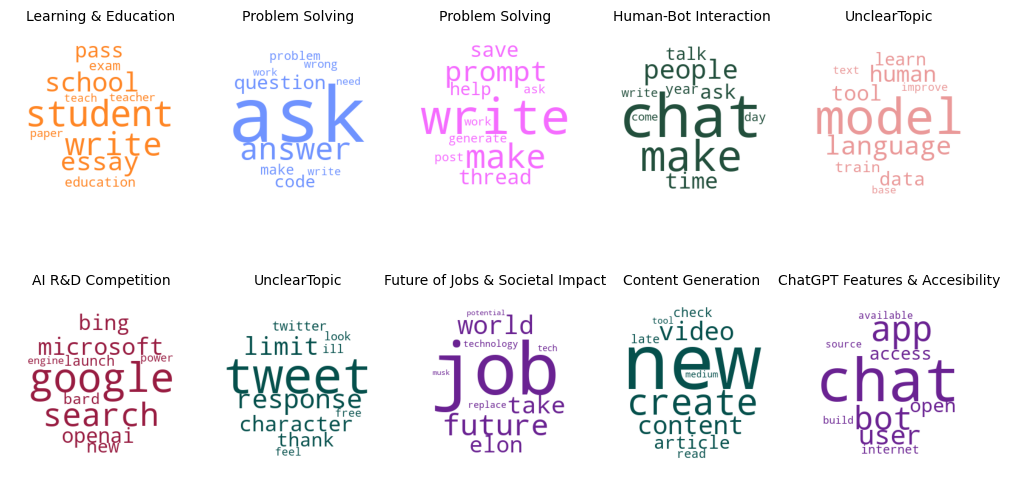

In [15]:
#Code in this cell was inspired by Selva Prabhakaran (source url: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ )

#Visualize all 10 topics identified

cols = [color for color in ['#ff8625','#6f93ff','#f56cff','#224f3c','#ea9999','#981c41','#05504c','#6a2292','#05504c','#6a2292']] #mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

cloud = WordCloud(stopwords=extra_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='hsv_r',
                  mask=mask,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = tweet_topic_LDA.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(lda_dict[i], fontdict=dict(size=10))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("TweetsTopics.jpg")
plt.show()

In [44]:
#Defining a classifier function to use for labelling each user with an industry 
def classifier(texts,model,topics_dict):
    #get probabilities list for each observation in list of tuples format [(cluster_no, probability)...]
  texts_clean = texts.apply(lambda t: model[dictionary.doc2bow(t)])

    # First: sort probabilities list by probability in descending order (list of tuples e.g. (cluster_no, probabilty))
    # Second: get cluster number of first element (highest probability) 
    # Third: convert cluster number (lda_dict key) to predefined cluser name (lda_dict value)
  texts_clean = texts_clean.apply( lambda t: topics_dict[sorted(t, reverse=True, key=cmp_to_key(lambda item1, item2: item1[1] - item2[1]))[0][0]] )
  return texts_clean

In [ ]:
#Classify the users descriptions into labels resulted from LDA model
tweets_prepro_df['tweet_topic']= classifier(tweets_prepro_df['tweet_content_tokens'],tweet_topic_LDA,lda_dict)

In [36]:
tweets_prepro_df.head()

,tweet_id,tweet_content_hashtags,tweet_content_clean,tweet_content_tokens_no_verbs,tweet_content_tokens,tweet_topic
0,1644446066748854281,[teaching],whats happening it asks and i reply that chat ...,"[world, video, class, alternative, fall, reply...","[world, video, class, alternative, fall, reply...",NaN
1,1644442136664764444,[],one in the depot is approximately mb in size t...,"[current, mib, mb, depot, correct, conversion,...","[current, mib, mb, depot, correct, conversion,...",NaN
2,1644437753721942044,[],ive converted to chatgpt,[],[],NaN
3,1644433541827280896,[chatgpt],asked if someone has a bmi of are they obese ...,"[health, doc, account, replace, risk, age, rep...","[health, doc, account, replace, risk, age, rep...",NaN
4,1644429028307406849,"[ChatGPT, AI, Hardware, blog]",how does chatgpt train its ai using advanced h...,"[blog, post, advanced, train, secret, explore,...","[blog, post, advanced, train, secret, explore,...",NaN


In [20]:
#TODO: if new topics need to be assigned remove comment below
#tweets_prepro_df.to_csv('Tweets_TopicLabelled.csv',index=False)

In [89]:
sentiment_df= pd.read_csv("data_files/Tweets_SentimentLabelled_PreLDA.csv")
sentiment_df['tweet_id']=sentiment_df['tweet_id'].astype(str)
sentiment_df.shape

(1640046, 12)

In [7]:
topics_df= pd.read_csv("data_files/Tweets_TopicLabelled.csv")
topics_df['tweet_id']=topics_df['tweet_id'].astype(str)
topics_df.shape

(1640046, 6)

In [94]:
full_df= sentiment_df.merge(topics_df,on="tweet_id",how="left")[['tweet_id','tweet_topic','sentiment']]
full_df.head()

,tweet_id,tweet_topic,sentiment
0,1644446066748854281,Human-Bot Interaction,Positive
1,1644442136664764444,Problem Solving,Neutral
2,1644437753721942044,Education,Neutral
3,1644433541827280896,Human-Bot Interaction,Negative
4,1644429028307406849,Content Generation,Positive


In [ ]:
#full_df.to_csv("Tweets_TOPIC_SENTIMENT.csv",index=False)

In [11]:
tweets=pd.read_csv("data_files/Tweets_TOPIC_SENTIMENT.csv")
tweets['tweet_id']=tweets['tweet_id'].astype(str)
tweets

,tweet_id,tweet_topic,sentiment
0,1644446066748854281,Human-Bot Interaction,Positive
1,1644442136664764444,Problem Solving,Neutral
2,1644437753721942044,Education,Neutral
3,1644433541827280896,Human-Bot Interaction,Negative
4,1644429028307406849,Content Generation,Positive
...,...,...,...
1640041,1632455286211371009,AI R&D Competition,Neutral
1640042,1632455296441360386,UnclearTopic,Positive
1640043,1632455301701189632,Content Generation,Positive
1640044,1632455315005509632,UnclearTopic,Positive


In [24]:
all_cols_data= pd.read_csv('data_files/tweets_data_condensed_FINAL.csv')
all_cols_data['tweet_id']=all_cols_data['tweet_id'].astype(str)
all_cols_data['usr_inreply_id']=all_cols_data['usr_inreply_id'].apply(lambda x: '%.0f' % x)
all_cols_data['usr_inreply_id'] =all_cols_data['usr_inreply_id'].astype(str)
all_cols_data.head(3)

,tweet_id,sentiment,tweet_topic,tweet_date,tweet_content,tweet_replycount,tweet_retweetcount,tweet_likecount,usr_verified,usr_follower_count,usr_location,usr_userid,usr_inreply_id
0,1644446066748854281,Positive,UnclearTopic,2023-04-07 21:04:29+00:00,"What's happening, it asks, and I reply that ch...",0,0,0,False,9,"Sacramento, CA",1476626055993561110,nan
1,1644442136664764444,Neutral,Code Assistance,2023-04-07 20:48:52+00:00,"...one in the depot is approximately 17,42 MB ...",1,0,1,False,55,Liberty City,1533967598802575361,1533967598802575360
2,1644437753721942044,Neutral,UnclearTopic,2023-04-07 20:31:27+00:00,I’ve converted to chatgpt,0,0,0,False,357,"the u.s., sadly",719368782,nan


In [25]:
all_cols_data.drop(columns=['sentiment','tweet_topic'],inplace=True)

In [33]:
#all_cols_data.merge(tweets,on='tweet_id',how='left').to_csv("tweets_data_condensed_FINAL.csv",index=False)